In [5]:
import pandas as pd
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt


In [6]:
def __smooth(y, npts, win="hanning"):

    from numpy import ones, convolve, hanning, nan

    if win == "hanning":
        win = hanning(npts)
    elif win == "boxcar":
        win = ones(npts)

    y_smooth = convolve(y, win/sum(win), mode='same')

    y_smooth[:npts//2] = nan
    y_smooth[-npts//2:] = nan
    return y_smooth

In [20]:
# path to data
path = "./data/"

# test run
filename = "romy_fsr_20240821T140958.csv"

# run 1
filename = "romy_fsr_20240822T123702.csv"

# free spectral range of ROMY
fsr = 8.94e6

# nth FSR peak
n = 12

# side length of cavity
L = 11.2

# perimeter of cavity
P = 3*L

In [21]:
df0 = pd.read_csv(path+filename)

starttime = obs.UTCDateTime(df0.datetime.iloc[0])

df0['time_sec'] = np.array([obs.UTCDateTime(_dt) - starttime for _dt in df0.datetime])

In [22]:
df = df0.copy()

fmode = df.x_hz.iloc[0]*1e-6

dbm_threshold = 100

df['x_mod'] = np.where(abs(df.y_dbm) < dbm_threshold, df.x_hz, np.nan)

df['x_mod_rel'] = df.x_mod - np.nanmean(df.x_mod[:100])

df['y_mod'] = np.where(abs(df.y_dbm) < dbm_threshold, df.y_dbm, np.nan)

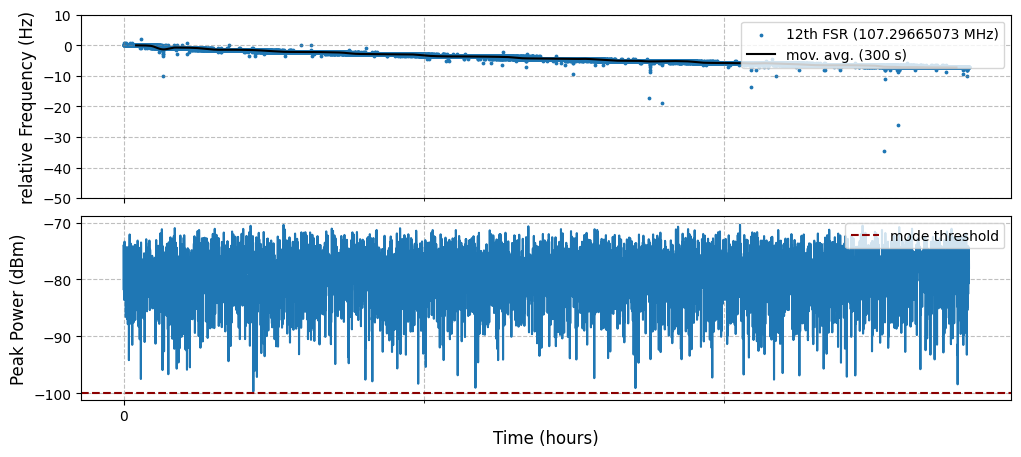

In [23]:
def __makeplot(df):

    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 2, 1

    xscale = 1

    tscale, tunit = 1/3600, "hours"

    ymin, ymax = -50, 10
    # df2 = df[(df.x_mod_rel > ymin) & (df.x_mod_rel < ymax)]

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tsec = 300
    ax[0].scatter(df['time_sec']*tscale, df.x_mod_rel, s=3, color="tab:blue", label=f"{n}th FSR ({fmode} MHz)")
    ax[0].plot(df['time_sec']*tscale, __smooth(df.x_mod_rel, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[0].ticklabel_format(useOffset=False)

    # ax000 = ax[0].twinx()
    # ax000.scatter(df2['time_sec']*tscale, -df2.disp_um, color="tab:red", s=3)
    # # ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
    # # ax000.set_yticks(np.linspace(ax000.get_yticks()[0], ax000.get_yticks()[-1], len(ax[0].get_yticks())))
    # ax000.set_ylabel("relative Perimeter ($\mu$m)", fontsize=font)

    ax[0].set_ylim(ymin, ymax)

    ax[1].plot(df['time_sec']*tscale, df.y_dbm)
    ax[1].axhline(-dbm_threshold, color="darkred", ls="--", label="mode threshold")

    for i in range(Nrow):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].legend(loc=1, fontsize=font-2)
        ax[i].xaxis.set_major_locator(MultipleLocator(5))
        ax[i].xaxis.set_minor_locator(MultipleLocator(1))

    ax[0].set_ylabel("relative Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel("Peak Power (dBm)", fontsize=font)
    ax[1].set_xlabel(f"Time ({tunit})", fontsize=font)

    plt.show();
    return fig

fig = __makeplot(df);


In [24]:
# df['disp_um'] = 1e6 * P * df.x_mod_rel / (n * fsr)

df['disp_um'] = (3e8 / (df.x_mod / n))

df['disp_um_rel'] = (3e8 / (df.x_mod / n)) - df.disp_um.iloc[0]


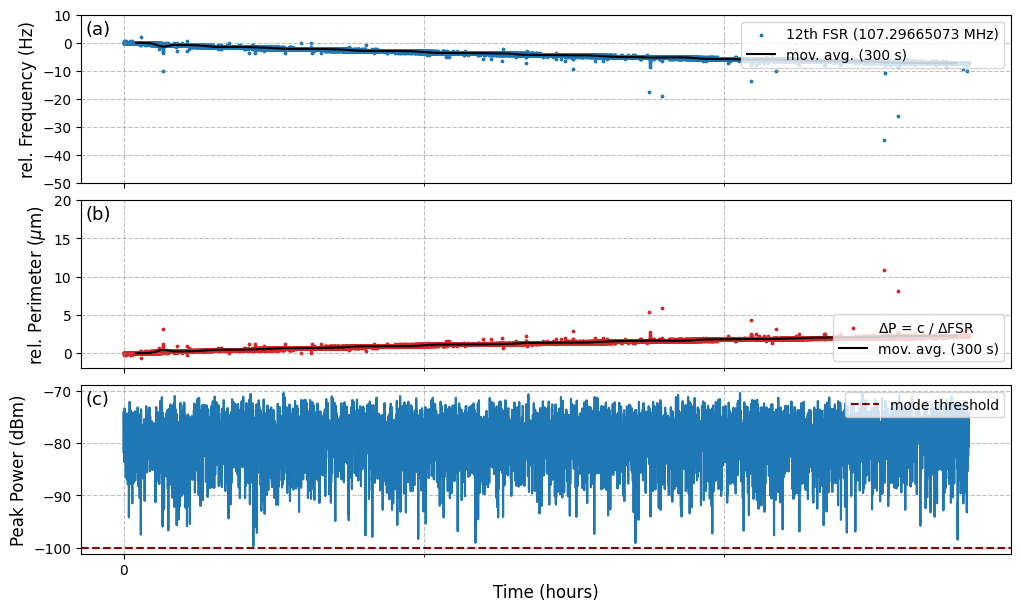

In [25]:
def __makeplot(df):

    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 3, 1

    xscale = 1

    tscale, tunit = 1/3600, "hours"

    dscale, dunit = 1e6, "$\mu$m"

    ymin, ymax = -50, 10

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 7), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tsec = 300
    ax[0].scatter(df['time_sec']*tscale, df.x_mod_rel, s=3, color="tab:blue", label=f"{n}th FSR ({fmode} MHz)")
    ax[0].plot(df['time_sec']*tscale, __smooth(df.x_mod_rel, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylim(ymin, ymax)

    ax[1].scatter(df['time_sec']*tscale, df.disp_um_rel*dscale, s=3, color="tab:red", label=f"$\Delta$P = c / $\Delta$FSR")
    ax[1].plot(df['time_sec']*tscale, __smooth(df.disp_um_rel*dscale, tsec), "k", label=f"mov. avg. ({tsec} s)", zorder=5)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylim(-2, 20)

    ax[2].plot(df['time_sec']*tscale, df.y_dbm, alpha=0.5)
    ax[2].plot(df['time_sec']*tscale, df.y_mod, color="tab:blue")
    ax[2].axhline(-dbm_threshold, color="darkred", ls="--", label="mode threshold")

    for i in range(Nrow):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].legend(loc=1, fontsize=font-2)
        ax[i].xaxis.set_major_locator(MultipleLocator(5))
        ax[i].xaxis.set_minor_locator(MultipleLocator(1))

    ax[1].legend(loc=4, fontsize=font-2)

    ax[0].set_ylabel(f"rel. Frequency (Hz)", fontsize=font)
    ax[1].set_ylabel(f"rel. Perimeter ({dunit})", fontsize=font)
    ax[2].set_ylabel(f"Peak Power (dBm)", fontsize=font)
    ax[2].set_xlabel(f"Time ({tunit})", fontsize=font)

    for _k, ll in enumerate(['(a)','(b)','(c)']):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot(df);
